## About the Dataset


Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

Dataset Link : https://www.kaggle.com/datasets/nelgiriyewithana/emotions

## Importing Libraries

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import neattext as nt
from neattext.functions import clean_text
import nltk
from nltk.tokenize import  word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix,classification_report
import seaborn as sns
import joblib

## Data Loading

In [119]:
data = pd.read_csv("text.csv")
data=data[['label','text']]
data

,label,text
0,4,i just feel really helpless and heavy hearted
1,0,ive enjoyed being able to slouch about relax a...
2,4,i gave up my internship with the dmrg and am f...
3,0,i dont know i feel so lost
4,4,i am a kindergarten teacher and i am thoroughl...
...,...,...
416804,2,i feel like telling these horny devils to find...
416805,3,i began to realize that when i was feeling agi...
416806,5,i feel very curious be why previous early dawn...
416807,3,i feel that becuase of the tyranical nature of...


## Data Preprocessing

In [120]:
#checking for duplicates
number_of_duplicates = data.duplicated().sum()
print(number_of_duplicates)

686


In [121]:
# Deleting duplicates
data=data.drop_duplicates()
number_of_duplicates = data.duplicated().sum()
print(number_of_duplicates)

0


label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64


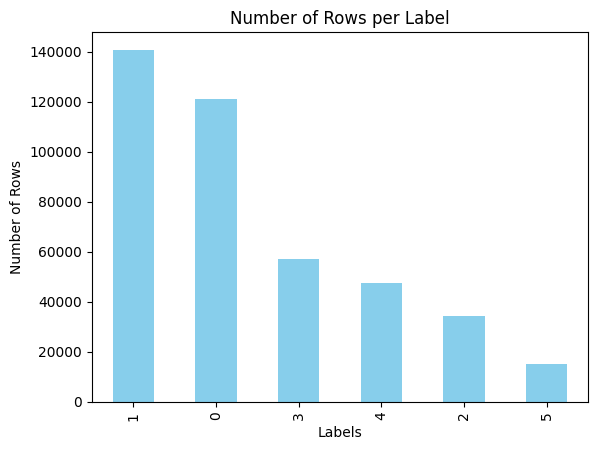

In [122]:
#checking value count for each label
label_counts = data['label'].value_counts()

print(label_counts)
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Label')
plt.show()

In [123]:
#Under sampling the dataset for each class.
desired_sample_size = 10000
balanced_dfs = []

for label in data['label'].unique():
    df_label = data[data['label'] == label]
    
    if len(df_label) >= desired_sample_size:
        df_label_downsampled = resample(df_label,replace=False,n_samples=desired_sample_size,random_state=42)
        balanced_dfs.append(df_label_downsampled)

df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['label'].value_counts())

label
0    10000
1    10000
4    10000
3    10000
2    10000
5    10000
Name: count, dtype: int64


## Data Cleaning

In [124]:
# punctuation,emojis, whitespace removal using neattext
text=[]
for i in df_balanced['text']:
    cleaned_text = clean_text(i, stopwords=False)
    text.append(cleaned_text)
df_balanced["text"]=text

In [125]:
# Splittng the text in training and testing as we need to train vectorizer
X = df_balanced.drop('label', axis=1) 
y = df_balanced['label']               
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
X_train.shape

(48000, 1)

In [127]:
X_test.shape

(12000, 1)

In [128]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [130]:
lemmatizer = WordNetLemmatizer()

In [131]:
# function for removing and lemmatizing the words
def preprocess(text):
  words_list = word_tokenize(text)

  filtered_list = []

  for word in words_list:
      if word.casefold() not in stop_words:
          filtered_list.append(word)
  lemma_text = [lemmatizer.lemmatize(word) for word in filtered_list]

  return lemma_text

In [132]:
# removing stopword and lemmatizing the words
preprocess_text=[]
for i in X_train['text']:

  t=preprocess(i)
  preprocess_text.append(t)


In [133]:
preprocessed_text = [' '.join(tokens) for tokens in preprocess_text]
len(preprocessed_text)

48000

## Vectorizing 

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_new = vectorizer.fit_transform(preprocessed_text)

In [136]:
#processing testing data 
preprocess_test_text=[]
for i in X_test['text']:

  t=preprocess(i)
  preprocess_test_text.append(t)

preprocessed_test_text = [' '.join(tokens) for tokens in preprocess_test_text]
X_test_new = vectorizer.transform(preprocessed_test_text)

## Model Development and evaluation

In [137]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_new, y_train)

MultinomialNB()

In [138]:
def evaluation(model,X_train,X_test,Y_train,Y_test):
    predictions_test = model.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions_test)
    print("Test_accuracy", accuracy)
    prediction_train = model.predict(X_train)
    accuracy=accuracy_score(Y_train,prediction_train)
    print("Training_accuracy",accuracy)
    precision = precision_score(y_test, predictions_test, average='weighted')  
    recall = recall_score(y_test, predictions_test, average='weighted')  
    f1 = f1_score(y_test, predictions_test, average='weighted')
    print("Precision",precision)
    print("Recall",recall)

    print("f1-score",f1)
    cm = confusion_matrix(Y_test, predictions_test)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(Y_test, predictions_test))






Test_accuracy 0.8674166666666666
Training_accuracy 0.930875
Precision 0.8683771218757518
Recall 0.8674166666666666
f1-score 0.8671861498580041


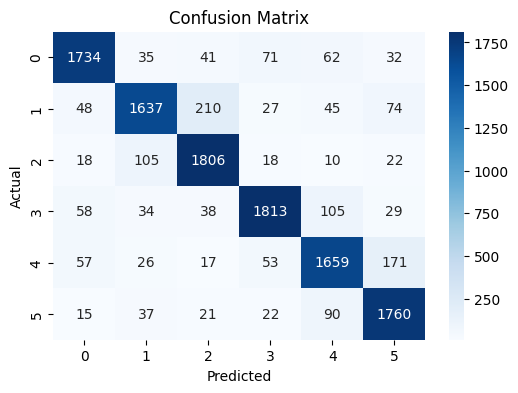

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1975
           1       0.87      0.80      0.84      2041
           2       0.85      0.91      0.88      1979
           3       0.90      0.87      0.89      2077
           4       0.84      0.84      0.84      1983
           5       0.84      0.90      0.87      1945

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



In [139]:
s= evaluation(nb_classifier,X_train_new,X_test_new,y_train,y_test)

In [140]:
svc_classifier = LinearSVC()
svc_classifier.fit(X_train_new, y_train)

LinearSVC()

Test_accuracy 0.9065
Training_accuracy 0.9647083333333333
Precision 0.9070812499637375
Recall 0.9065
f1-score 0.9062259484903079


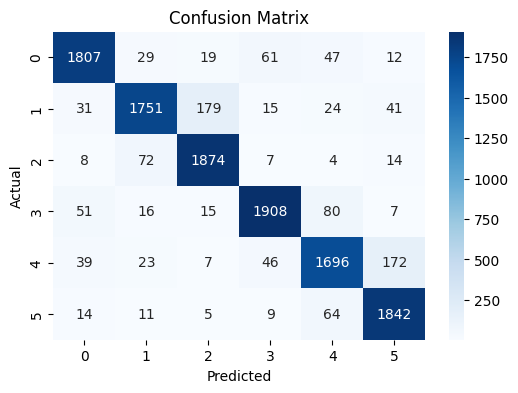

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1975
           1       0.92      0.86      0.89      2041
           2       0.89      0.95      0.92      1979
           3       0.93      0.92      0.93      2077
           4       0.89      0.86      0.87      1983
           5       0.88      0.95      0.91      1945

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



In [141]:
s= evaluation(svc_classifier,X_train_new,X_test_new,y_train,y_test)

## Regularizing the model as there is slight overfitting

In [142]:
r_svc_classifier = LinearSVC(C=0.1)
r_svc_classifier.fit(X_train_new, y_train)

LinearSVC(C=0.1)

Test_accuracy 0.9155
Training_accuracy 0.9373958333333333
Precision 0.9170021749707893
Recall 0.9155
f1-score 0.9150570077860769


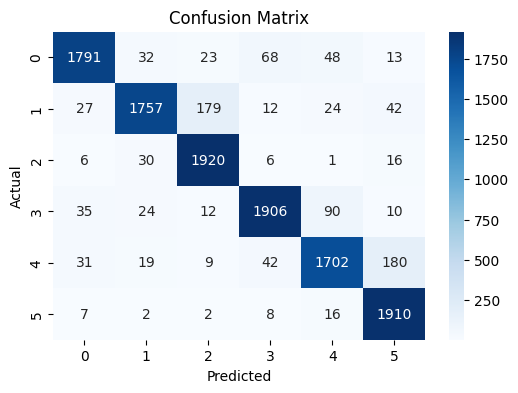

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1975
           1       0.94      0.86      0.90      2041
           2       0.90      0.97      0.93      1979
           3       0.93      0.92      0.93      2077
           4       0.90      0.86      0.88      1983
           5       0.88      0.98      0.93      1945

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



In [143]:
s= evaluation(r_svc_classifier,X_train_new,X_test_new,y_train,y_test)

## Saving the model

In [144]:
joblib.dump(r_svc_classifier, 'emotion_model.pkl')
joblib.dump(vectorizer, 'vectorizer_model.pkl')

['vectorizer_model.pkl']

## Testing script

In [145]:
vectorization_model=joblib.load('vectorizer_model.pkl')
classification_model = joblib.load('emotion_model.pkl')

def testing_script(input,vectorizer,classification_model):
    cleaned_text = clean_text(input, stopwords=False)
    words_list = word_tokenize(cleaned_text)
    filtered_list = []

    for word in words_list:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    lemma_text = [lemmatizer.lemmatize(word) for word in filtered_list]
    p_text= ' '.join(lemma_text)
    x_test=vectorizer.transform([p_text])
    prediction= classification_model.predict(x_test)
    label={0:"Sadness",1:"joy",2:"love",3:"Anger",4:"Fear",5:"Surprise"}
    return label[prediction[0]]

input_text="i seriously hate one subject to death but now i feel reluctant to drop it"
result = testing_script(input_text,vectorization_model,classification_model)
result


'Fear'